# ILS vs Introgressed Gene Trees Analysis

In [1]:
# Import packages.
from matplotlib import pyplot as plt
import msprime
import numpy as np
import pandas as pd
import tskit
from scipy import stats as stats

In [2]:
# Define an IUA model of introgression.
def iua_human_model(f):
    # Intialize demographic model.
    iua_model = msprime.Demography()
    # We assume constant and equal effective population sizes for
    # all lineages.
    iua_model.add_population(name='P1', initial_size=10_000)
    iua_model.add_population(name='P2', initial_size=10_000)
    iua_model.add_population(name='P3', initial_size=10_000)
    iua_model.add_population(name='P12', initial_size=10_000)
    iua_model.add_population(name='P123', initial_size=10_000)
    # Introgression from the Neanderthal to the Eurasian lineage
    # occuring 1,600 generations ago with a probability of f.
    iua_model.add_mass_migration(
        time=1_600, source='P2', dest='P3', proportion=f,
    )
    # The African and Eurasian lineages merge into the anatomically
    # modern human lineage 4,000 generations ago.
    iua_model.add_population_split(
        time=4_000, derived=['P1', 'P2'], ancestral='P12',
    )
    # The anatomically modern human and Neanderthal lineages merge
    # into the ancestral human lineage 16,000 generations ago.
    iua_model.add_population_split(
        time=16_000, derived=['P12', 'P3'], ancestral='P123',
    )
    return iua_model

In [3]:
# Define a function to disentangle the eight possible coalescent histories for the IUA model.
def iua_coal_hists(ts, tp3, tgf):
    """
    ###########################################################################
    INPUT
        ts: Simulated tree sequence.
        tp3: Time (P12, P3) diverged from P123.
        tgf: Time of the introgression event.
    ---------------------------------------------------------------------------
    OUTPUT
        0: The first coalesent event is between P1 and P2, and it is
           neutral+LS.
        1: The first coalesent event is between P1 and P2, and it is
           neutral+ILS.
        2: The first coalesent event is between P1 and P2, and it is
           introgression+ILS.
        3: The first coalesent event is between P1 and P3, and it is
           neutral+ILS.
        4: The first coalesent event is between P1 and P3, and it is
           introgression+ILS.
        5: The first coalesent event is between P2 and P3, and it is
           neutral+ILS.
        6: The first coalesent event is between P2 and P3, and it is
           introgression+LS
        7: The first coalesent event is between P2 and P3, and it is
           introgression+ILS
    ###########################################################################
    """
    # Grab the first and only tree in the tree sequence.
    tree = ts.first()
    # If the first coalescent event is between P1 and P2, e.g., indicies 0
    # and 1...
    if (tree.children(3) == (0, 1)):
        # Grab the birth time for the node of the first coalescent event.
        coal_time = tree.time(3)
        # If the first coalescent event takes place before T_{P3}.
        if (coal_time < tp3):
            # Record that the first coalescent history is LS(P1, P2).
            coal_history = 0
        # Else...
        else:
            # Dump the migrations table.
            migration_table = ts.dump_tables().migrations
            # If the first migration event is NOT the introgression event...
            if (migration_table.time[0] != tgf):
                # Record that the first coalescent history is neutral+ILS(P1, P2).
                coal_history = 1
            # Else...
            else:
                # Track the P1 and P2 population samples.
                tree = ts.first(tracked_samples=[1])
                # Extract all information needed for computing introgressed
                # segments from the migrations table.
                migration_nodes = migration_table.node
                migration_sources = migration_table.source
                migration_destinations = migration_table.dest
                migration_times = migration_table.time
                migration_left = migration_table.left
                migration_right = migration_table.right
                # Build masks for the introgressing population and the
                # introgression time.
                introgression_mask = migration_destinations == 2
                within_time_mask = migration_times[introgression_mask] == tgf
                # Get introgressing nodes for given introgression time and tree coordinates
                introgressing_nodes = migration_nodes[introgression_mask][within_time_mask][0] # Index 0 only for single trees.
                introgressing_left = migration_left[introgression_mask][within_time_mask][0] # Index 0 only for single trees.
                introgressing_right = migration_right[introgression_mask][within_time_mask][0] # Index 0 only for single trees.
                # If the tree interval is covered, partially or fully, by the migrating node then it is introgressed.
                if (tree.interval[0] >= introgressing_left and tree.interval[0] < introgressing_right)\
                    or (tree.interval[1] > introgressing_left and tree.interval[1] <= introgressing_right)\
                    or (tree.interval[0] < introgressing_left and tree.interval[1] > introgressing_right)\
                    or (tree.interval[0] == introgressing_left and tree.interval[1] == introgressing_right):
                    # If the introgressing node has a leaf in the recipient population...
                    if (tree.num_tracked_samples(introgressing_nodes) > 0):
                        # Record that the first coalesent event is between P1 and P2,
                        # and it is introgression+ILS.
                        coal_history = 2
                    # Else...
                    else:
                        # Record that the first coalesent event is between P1 and P2, and
                        # it is neutral+ILS.
                        coal_history = 1
    # Else-if the first coalescent event is between P1 and P3, e.g., indicies 0
    # and 2....
    elif (tree.children(3) == (0, 2)):
        # Track the P1 population sample.
        tree = ts.first(tracked_samples=[1])
        # Dump the migrations table.
        migration_table = ts.dump_tables().migrations
        # If the first migration event is NOT the introgression event...
        if (migration_table.time[0] != tgf):
            # Record that the first coalesent event is between P1 and P3, and
            # it is neutral+ILS.
            coal_history = 3
        # Else...
        else:
            # Extract all information needed for computing introgressed
            # segments from the migrations table.
            migration_nodes = migration_table.node
            migration_sources = migration_table.source
            migration_destinations = migration_table.dest
            migration_times = migration_table.time
            migration_left = migration_table.left
            migration_right = migration_table.right
            # Build masks for the introgressing population and the
            # introgression time.
            introgression_mask = migration_destinations == 2
            within_time_mask = migration_times[introgression_mask] == tgf
            # Get introgressing nodes for given introgression time and tree coordinates
            introgressing_nodes = migration_nodes[introgression_mask][within_time_mask][0] # Index 0 only for single trees.
            introgressing_left = migration_left[introgression_mask][within_time_mask][0] # Index 0 only for single trees.
            introgressing_right = migration_right[introgression_mask][within_time_mask][0] # Index 0 only for single trees.
            # If the tree interval is covered, partially or fully, by the migrating node then it is introgressed.
            if (tree.interval[0] >= introgressing_left and tree.interval[0] < introgressing_right)\
                or (tree.interval[1] > introgressing_left and tree.interval[1] <= introgressing_right)\
                or (tree.interval[0] < introgressing_left and tree.interval[1] > introgressing_right)\
                or (tree.interval[0] == introgressing_left and tree.interval[1] == introgressing_right):
                # If the introgressing node has a leaf in the recipient population...
                if (tree.num_tracked_samples(introgressing_nodes) > 0):
                    # Record that the first coalesent event is between P1 and P3,
                    # and it is introgression+ILS.
                    coal_history = 4
                # Else...
                else:
                    # Record that the first coalesent event is between P1 and P3, and
                    # it is neutral+ILS.
                    coal_history = 3
    # Else...
    else:
        # Track the P2 population sample.
        tree = ts.first(tracked_samples=[1])
        # Dump the migrations table.
        migration_table = ts.dump_tables().migrations
        # If the first migration event is NOT the introgression event...
        if (migration_table.time[0] != tgf):
            # Record that the first coalesent event is between P2 and P3, and
            # it is neutral+ILS.
            coal_history = 5
        # Else...
        else:
            # Grab the birth time for the node of the first coalescent event.
            coal_time = tree.time(3)
            # If the first coalescent event takes place before T_{P3}.
            if (coal_time < tp3):
                # Record that the first coalesent event is between P2 and P3,
                # and it is introgression+LS.
                coal_history = 6
            # Else...
            else:
                # Extract all information needed for computing introgressed
                # segments from the migrations table.
                migration_nodes = migration_table.node
                migration_sources = migration_table.source
                migration_destinations = migration_table.dest
                migration_times = migration_table.time
                migration_left = migration_table.left
                migration_right = migration_table.right
                # Build masks for the introgressing population and the
                # introgression time.
                introgression_mask = migration_destinations == 2
                within_time_mask = migration_times[introgression_mask] == tgf
                # Get introgressing nodes for given introgression time and tree coordinates
                introgressing_nodes = migration_nodes[introgression_mask][within_time_mask][0] # Index 0 only for single trees.
                introgressing_left = migration_left[introgression_mask][within_time_mask][0] # Index 0 only for single trees.
                introgressing_right = migration_right[introgression_mask][within_time_mask][0] # Index 0 only for single trees.
                # If the tree interval is covered, partially or fully, by the migrating node then it is introgressed.
                if (tree.interval[0] >= introgressing_left and tree.interval[0] < introgressing_right)\
                    or (tree.interval[1] > introgressing_left and tree.interval[1] <= introgressing_right)\
                    or (tree.interval[0] < introgressing_left and tree.interval[1] > introgressing_right)\
                    or (tree.interval[0] == introgressing_left and tree.interval[1] == introgressing_right):
                    # If the introgressing node has a leaf in the recipient population...
                    if (tree.num_tracked_samples(introgressing_nodes) > 0):
                        # Record that the first coalesent event is between P2 and P3,
                        # and it is introgression+ILS.
                        coal_history = 7
                    # Else...
                    else:
                        # Record that the first coalesent event is between P2 and P3, and
                        # it is neutral+ILS.
                        coal_history = 5
    return coal_history

In [4]:
# Define a function to calculate the analytical solutions for the coalescent histories.
def calc_coal_history_expectations(f, tp3_tp2, tp3_tgf, n):
    # Intilize times.
    neutral = (((tp3_tp2) / (2 * n)) * -1)
    introgression = (((tp3_tgf) / (2 * n)) * -1)
    # Intialize coalescent histories counts.
    coal_hist_dicc = {
        0: ((1 - f) * (1 - np.exp(neutral))) * 100_000, 
        1: ((1 - f) * (np.exp(neutral) / 3)) * 100_000, 
        2: ((f) * (np.exp(introgression) / 3)) * 100_000,
        3: ((1 - f) * (np.exp(neutral) / 3)) * 100_000,
        4: ((f) * (np.exp(introgression) / 3)) * 100_000, 
        5: ((1 - f) * (np.exp(neutral) / 3)) * 100_000,
        6: ((f) * (1 - np.exp(introgression))) * 100_000,
        7: ((f) * (np.exp(introgression) / 3)) * 100_000, 
    }
    return coal_hist_dicc

In [5]:
# As a proof of concept simulate 100_000 gene trees and determine the coalescent histories.
tsg = msprime.sim_ancestry(
    samples=[
        msprime.SampleSet(1, ploidy=1, population='P1'),
        msprime.SampleSet(1, ploidy=1, population='P2'),
        msprime.SampleSet(1, ploidy=1, population='P3'),
    ],
    demography=iua_human_model(0.03),
    sequence_length=50_000,
    record_migrations=True,
    random_seed=42,
    num_replicates=100_000,
)
# Intialize coalescent histories counts.
sim_dicc = {
    0: 0, 1: 0, 2: 0, 3: 0,
     4: 0, 5: 0, 6: 0, 7: 0, 
}
# For every tree sequence in the tree sequence generator...
for i, ts in enumerate(tsg):
    # Determine the coalescent history.
    coal_hist = iua_coal_hists(ts, 16_000, 1_600)
    # Keep count of each coalescent history.
    sim_dicc[coal_hist] += 1
# Divide by the total number of replicates.
for key in sim_dicc.keys():
    sim_dicc[key] / 100_000
# Determine the expected frequency of coalescent histories.
exp_dicc = calc_coal_history_expectations(0.03, (16_000-4_000), (16_000-1_600), 10_000)

In [6]:
# For every coalescent history...
for hist in range(8):
    print('SIM: {0} vs EXP: {1} (COAL HIST {2})'.format(sim_dicc[hist], round(exp_dicc[hist]), hist))

SIM: 43719 vs EXP: 43765 (COAL HIST 0)
SIM: 17922 vs EXP: 17745 (COAL HIST 1)
SIM: 468 vs EXP: 487 (COAL HIST 2)
SIM: 17812 vs EXP: 17745 (COAL HIST 3)
SIM: 465 vs EXP: 487 (COAL HIST 4)
SIM: 17616 vs EXP: 17745 (COAL HIST 5)
SIM: 1498 vs EXP: 1540 (COAL HIST 6)
SIM: 500 vs EXP: 487 (COAL HIST 7)


In [7]:
# Define a function to extract observed introgression values.
def load_obs_vals(prefix, f):
    # Intializ a window size list.
    wind_size = [10, 20, 30, 40, 50]
    # Intialize a dictionary.
    obs_dicc = {}
    # For every window...
    for wind in wind_size:
        # Fill the dictionary.
        obs_dicc[wind] = {}
        obs_dicc[wind]['abba'] = np.loadtxt(
            './ils_v_intro/{0}kb/{1}/{2}/abba.csv.gz'.format(wind, prefix, f),
            delimiter=',',
        )
        obs_dicc[wind]['baba'] = np.loadtxt(
            './ils_v_intro/{0}kb/{1}/{2}/baba.csv.gz'.format(wind, prefix, f),
            delimiter=',',
        )
        obs_dicc[wind]['baaa'] = np.loadtxt(
            './ils_v_intro/{0}kb/{1}/{2}/baaa.csv.gz'.format(wind, prefix, f),
            delimiter=',',
        )
        obs_dicc[wind]['abaa'] = np.loadtxt(
            './ils_v_intro/{0}kb/{1}/{2}/abaa.csv.gz'.format(wind, prefix, f),
            delimiter=',',
        )
        obs_dicc[wind]['d'] = np.loadtxt(
            './ils_v_intro/{0}kb/{1}/{2}/d.csv.gz'.format(wind, prefix, f),
            delimiter=',',
        )
        obs_dicc[wind]['danc'] = np.loadtxt(
            './ils_v_intro/{0}kb/{1}/{2}/danc.csv.gz'.format(wind, prefix, f),
            delimiter=',',
        )
        obs_dicc[wind]['dplus'] = np.loadtxt(
            './ils_v_intro/{0}kb/{1}/{2}/dplus.csv.gz'.format(wind, prefix, f),
            delimiter=',',
        )
    return obs_dicc

In [8]:
# Load the results.
n_ils_f00_dicc = load_obs_vals('n_ils', 0.0)
n_ils_f03_dicc = load_obs_vals('n_ils', 0.03)
intro_f03_dicc = load_obs_vals('intro', 0.03)

In [9]:
# Define the index.
wind_idx = ['10kb', '20kb', '30kb', '40kb', '50kb']
# Define a dictionary.
n_ils_f00_summary = {
    r'$D$ ($\mu$)': [], r'$D$ ($\sigma$)': [],
    r'$D_{anc}$ ($\mu$)': [], r'$D_{anc}$ ($\sigma$)': [],
    r'$D+$ ($\mu$)': [], r'$D+$ ($\sigma$)': [],
    r'$ABBA$ ($\mu$)': [], r'$ABBA$ ($\sigma$)': [],
    r'$BABA$ ($\mu$)': [], r'$BABA$ ($\sigma$)': [],
    r'$BAAA$ ($\mu$)': [], r'$BAAA$ ($\sigma$)': [],
    r'$ABAA$ ($\mu$)': [], r'$ABAA$ ($\sigma$)': [],
}
n_ils_f03_summary = {
    r'$D$ ($\mu$)': [], r'$D$ ($\sigma$)': [],
    r'$D_{anc}$ ($\mu$)': [], r'$D_{anc}$ ($\sigma$)': [],
    r'$D+$ ($\mu$)': [], r'$D+$ ($\sigma$)': [],
    r'$ABBA$ ($\mu$)': [], r'$ABBA$ ($\sigma$)': [],
    r'$BABA$ ($\mu$)': [], r'$BABA$ ($\sigma$)': [],
    r'$BAAA$ ($\mu$)': [], r'$BAAA$ ($\sigma$)': [],
    r'$ABAA$ ($\mu$)': [], r'$ABAA$ ($\sigma$)': [],
}
intro_f03_summary = {
    r'$D$ ($\mu$)': [], r'$D$ ($\sigma$)': [],
    r'$D_{anc}$ ($\mu$)': [], r'$D_{anc}$ ($\sigma$)': [],
    r'$D+$ ($\mu$)': [], r'$D+$ ($\sigma$)': [],
    r'$ABBA$ ($\mu$)': [], r'$ABBA$ ($\sigma$)': [],
    r'$BABA$ ($\mu$)': [], r'$BABA$ ($\sigma$)': [],
    r'$BAAA$ ($\mu$)': [], r'$BAAA$ ($\sigma$)': [],
    r'$ABAA$ ($\mu$)': [], r'$ABAA$ ($\sigma$)': [],
}
# For every window size...
for wind in [10, 20, 30, 40, 50]:
    # Fill the dictionaries.
    n_ils_f00_summary[r'$D$ ($\mu$)'].append(np.nanmean(n_ils_f00_dicc[wind]['d']))
    n_ils_f00_summary[r'$D$ ($\sigma$)'].append(np.nanstd(n_ils_f00_dicc[wind]['d']))
    n_ils_f00_summary[r'$D_{anc}$ ($\mu$)'].append(np.nanmean(n_ils_f00_dicc[wind]['danc']))
    n_ils_f00_summary[r'$D_{anc}$ ($\sigma$)'].append(np.nanstd(n_ils_f00_dicc[wind]['danc']))
    n_ils_f00_summary[r'$D+$ ($\mu$)'].append(np.nanmean(n_ils_f00_dicc[wind]['dplus']))
    n_ils_f00_summary[r'$D+$ ($\sigma$)'].append(np.nanstd(n_ils_f00_dicc[wind]['dplus']))
    n_ils_f00_summary[r'$ABBA$ ($\mu$)'].append(np.nanmean(n_ils_f00_dicc[wind]['abba']))
    n_ils_f00_summary[r'$ABBA$ ($\sigma$)'].append(np.nanstd(n_ils_f00_dicc[wind]['abba']))
    n_ils_f00_summary[r'$BABA$ ($\mu$)'].append(np.nanmean(n_ils_f00_dicc[wind]['baba']))
    n_ils_f00_summary[r'$BABA$ ($\sigma$)'].append(np.nanstd(n_ils_f00_dicc[wind]['baba']))
    n_ils_f00_summary[r'$BAAA$ ($\mu$)'].append(np.nanmean(n_ils_f00_dicc[wind]['baaa']))
    n_ils_f00_summary[r'$BAAA$ ($\sigma$)'].append(np.nanstd(n_ils_f00_dicc[wind]['baaa']))
    n_ils_f00_summary[r'$ABAA$ ($\mu$)'].append(np.nanmean(n_ils_f00_dicc[wind]['abaa']))
    n_ils_f00_summary[r'$ABAA$ ($\sigma$)'].append(np.nanstd(n_ils_f00_dicc[wind]['abaa']))
    n_ils_f03_summary[r'$D$ ($\mu$)'].append(np.nanmean(n_ils_f03_dicc[wind]['d']))
    n_ils_f03_summary[r'$D$ ($\sigma$)'].append(np.nanstd(n_ils_f03_dicc[wind]['d']))
    n_ils_f03_summary[r'$D_{anc}$ ($\mu$)'].append(np.nanmean(n_ils_f03_dicc[wind]['danc']))
    n_ils_f03_summary[r'$D_{anc}$ ($\sigma$)'].append(np.nanstd(n_ils_f03_dicc[wind]['danc']))
    n_ils_f03_summary[r'$D+$ ($\mu$)'].append(np.nanmean(n_ils_f03_dicc[wind]['dplus']))
    n_ils_f03_summary[r'$D+$ ($\sigma$)'].append(np.nanstd(n_ils_f03_dicc[wind]['dplus']))
    n_ils_f03_summary[r'$ABBA$ ($\mu$)'].append(np.nanmean(n_ils_f03_dicc[wind]['abba']))
    n_ils_f03_summary[r'$ABBA$ ($\sigma$)'].append(np.nanstd(n_ils_f03_dicc[wind]['abba']))
    n_ils_f03_summary[r'$BABA$ ($\mu$)'].append(np.nanmean(n_ils_f03_dicc[wind]['baba']))
    n_ils_f03_summary[r'$BABA$ ($\sigma$)'].append(np.nanstd(n_ils_f03_dicc[wind]['baba']))
    n_ils_f03_summary[r'$BAAA$ ($\mu$)'].append(np.nanmean(n_ils_f03_dicc[wind]['baaa']))
    n_ils_f03_summary[r'$BAAA$ ($\sigma$)'].append(np.nanstd(n_ils_f03_dicc[wind]['baaa']))
    n_ils_f03_summary[r'$ABAA$ ($\mu$)'].append(np.nanmean(n_ils_f03_dicc[wind]['abaa']))
    n_ils_f03_summary[r'$ABAA$ ($\sigma$)'].append(np.nanstd(n_ils_f03_dicc[wind]['abaa']))
    intro_f03_summary[r'$D$ ($\mu$)'].append(np.nanmean(intro_f03_dicc[wind]['d']))
    intro_f03_summary[r'$D$ ($\sigma$)'].append(np.nanstd(intro_f03_dicc[wind]['d']))
    intro_f03_summary[r'$D_{anc}$ ($\mu$)'].append(np.nanmean(intro_f03_dicc[wind]['danc']))
    intro_f03_summary[r'$D_{anc}$ ($\sigma$)'].append(np.nanstd(intro_f03_dicc[wind]['danc']))
    intro_f03_summary[r'$D+$ ($\mu$)'].append(np.nanmean(intro_f03_dicc[wind]['dplus']))
    intro_f03_summary[r'$D+$ ($\sigma$)'].append(np.nanstd(intro_f03_dicc[wind]['dplus']))
    intro_f03_summary[r'$ABBA$ ($\mu$)'].append(np.nanmean(intro_f03_dicc[wind]['abba']))
    intro_f03_summary[r'$ABBA$ ($\sigma$)'].append(np.nanstd(intro_f03_dicc[wind]['abba']))
    intro_f03_summary[r'$BABA$ ($\mu$)'].append(np.nanmean(intro_f03_dicc[wind]['baba']))
    intro_f03_summary[r'$BABA$ ($\sigma$)'].append(np.nanstd(intro_f03_dicc[wind]['baba']))
    intro_f03_summary[r'$BAAA$ ($\mu$)'].append(np.nanmean(intro_f03_dicc[wind]['baaa']))
    intro_f03_summary[r'$BAAA$ ($\sigma$)'].append(np.nanstd(intro_f03_dicc[wind]['baaa']))
    intro_f03_summary[r'$ABAA$ ($\mu$)'].append(np.nanmean(intro_f03_dicc[wind]['abaa']))
    intro_f03_summary[r'$ABAA$ ($\sigma$)'].append(np.nanstd(intro_f03_dicc[wind]['abaa']))
# Build the dataframes.
n_ils_f00_df = pd.DataFrame(data=n_ils_f00_summary, index=wind_idx)
n_ils_f03_df = pd.DataFrame(data=n_ils_f03_summary, index=wind_idx)
intro_f03_df = pd.DataFrame(data=n_ils_f03_summary, index=wind_idx)

In [10]:
# View the ILS results for f = 0.
n_ils_f00_df

,$D$ ($\mu$),$D$ ($\sigma$),$D_{anc}$ ($\mu$),$D_{anc}$ ($\sigma$),$D+$ ($\mu$),$D+$ ($\sigma$),$ABBA$ ($\mu$),$ABBA$ ($\sigma$),$BABA$ ($\mu$),$BABA$ ($\sigma$),$BAAA$ ($\mu$),$BAAA$ ($\sigma$),$ABAA$ ($\mu$),$ABAA$ ($\sigma$)
10kb,-0.007479,0.999972,0.007751,0.468523,0.007526,0.508474,0.999108,2.472177,0.995392,2.426781,4.667073,3.342310,4.580108,3.280347
20kb,-0.008622,0.999963,0.026571,0.347139,0.025505,0.415560,1.978108,4.674569,2.004681,4.715707,9.399075,5.714885,8.939297,5.682127
30kb,-0.008900,0.999960,0.025480,0.315756,0.024558,0.397174,2.982370,6.923513,3.008760,6.936501,13.804178,8.102640,13.217805,8.185034
40kb,-0.007852,0.999969,0.019790,0.310148,0.018479,0.395580,3.975504,9.173359,4.009835,9.173256,18.081283,10.661027,17.494254,10.721465
50kb,-0.010237,0.999948,0.013298,0.306165,0.011996,0.393149,4.971497,11.395133,5.018723,11.487071,22.331142,13.144919,21.866757,13.252755


In [11]:
# View the ILS results for f = 0.03.
n_ils_f03_df

,$D$ ($\mu$),$D$ ($\sigma$),$D_{anc}$ ($\mu$),$D_{anc}$ ($\sigma$),$D+$ ($\mu$),$D+$ ($\sigma$),$ABBA$ ($\mu$),$ABBA$ ($\sigma$),$BABA$ ($\mu$),$BABA$ ($\sigma$),$BAAA$ ($\mu$),$BAAA$ ($\sigma$),$ABAA$ ($\mu$),$ABAA$ ($\sigma$)
10kb,-0.007453,0.999972,0.016327,0.446520,0.016183,0.489085,1.000225,2.475318,0.995043,2.427330,4.739823,3.304751,4.612175,3.262396
20kb,-0.008626,0.999963,0.031306,0.336348,0.030244,0.406457,1.980059,4.678460,2.001746,4.708888,9.480021,5.666808,8.968849,5.658907
30kb,-0.008896,0.999960,0.028090,0.311580,0.027127,0.393694,2.987138,6.934843,3.005201,6.933136,13.869573,8.065015,13.234265,8.160836
40kb,-0.007975,0.999968,0.021204,0.308376,0.019848,0.394131,3.981767,9.191111,4.008412,9.176472,18.124869,10.641150,17.500901,10.707482
50kb,-0.010137,0.999949,0.013764,0.306039,0.012441,0.393106,4.977486,11.404927,5.019566,11.496703,22.347698,13.154369,21.860204,13.240940


In [12]:
# View the introgression results for f = 0.03.
intro_f03_df

,$D$ ($\mu$),$D$ ($\sigma$),$D_{anc}$ ($\mu$),$D_{anc}$ ($\sigma$),$D+$ ($\mu$),$D+$ ($\sigma$),$ABBA$ ($\mu$),$ABBA$ ($\sigma$),$BABA$ ($\mu$),$BABA$ ($\sigma$),$BAAA$ ($\mu$),$BAAA$ ($\sigma$),$ABAA$ ($\mu$),$ABAA$ ($\sigma$)
10kb,-0.007453,0.999972,0.016327,0.446520,0.016183,0.489085,1.000225,2.475318,0.995043,2.427330,4.739823,3.304751,4.612175,3.262396
20kb,-0.008626,0.999963,0.031306,0.336348,0.030244,0.406457,1.980059,4.678460,2.001746,4.708888,9.480021,5.666808,8.968849,5.658907
30kb,-0.008896,0.999960,0.028090,0.311580,0.027127,0.393694,2.987138,6.934843,3.005201,6.933136,13.869573,8.065015,13.234265,8.160836
40kb,-0.007975,0.999968,0.021204,0.308376,0.019848,0.394131,3.981767,9.191111,4.008412,9.176472,18.124869,10.641150,17.500901,10.707482
50kb,-0.010137,0.999949,0.013764,0.306039,0.012441,0.393106,4.977486,11.404927,5.019566,11.496703,22.347698,13.154369,21.860204,13.240940


In [13]:
# Define a function to plot histograms.
def plot_hists(
    stat, title, color,
    n_ils_f00=n_ils_f00_dicc,
    n_ils_f03=n_ils_f03_dicc,
    intro_f03=intro_f03_dicc,
):
    # Intialize windows lists.
    wind_label = [
        r'$\bf{A.}$'+' 10kb Windows',
        r'$\bf{B.}$'+' 20kb  Windows',
        r'$\bf{C.}$'+' 30kb  Windows',
        r'$\bf{D.}$'+' 40kb  Windows',
        r'$\bf{E.}$'+' 50kb  Windows',
    ]
    wind_size = [10, 20, 30, 40, 50]
    # Intialize the style.
    plt.rcParams.update({'font.family': 'serif', 'font.size': 10})
    # Intialize the figure.
    fig, axes = plt.subplots(
        3, 5, figsize=(12, 8), dpi=300.0, sharex=True, sharey=True,
        facecolor='white', constrained_layout=True,
    )
    # For every window...
    for idx in range(len(wind_size)):
        # Grab the size and labe.
        size = wind_size[idx]
        label = wind_label[idx]
        # Plot the distributions.
        axes[0, idx].hist(n_ils_f00[size][stat], histtype='step', lw=3, color=color)
        axes[1, idx].hist(n_ils_f03[size][stat], histtype='step', lw=3, color=color)
        axes[2, idx].hist(intro_f03[size][stat], histtype='step', lw=3, color=color)
        # Plot the title.
        axes[0, idx].set_title(label)
        # Despine the axes.
        axes[0, idx].spines['top'].set_visible(False)
        axes[0, idx].spines['right'].set_visible(False)
        axes[1, idx].spines['top'].set_visible(False)
        axes[1, idx].spines['right'].set_visible(False)
        axes[2, idx].spines['top'].set_visible(False)
        axes[2, idx].spines['right'].set_visible(False)
    # Label the axes.
    axes[2, 2].set_xlabel(title+' Values', size=14)
    axes[0, 0].set_ylabel('Frequency')
    axes[1, 0].set_ylabel('Frequency')
    axes[2, 0].set_ylabel('Frequency')
    # Intialize row labels.
    rows = ['ILS Trees (f = 0)', 'ILS Trees (f = 0.03)', 'Intro. Trees (f = 0.03)']
    # For every row on the first column.
    for ax, row in zip(axes[:,0], rows):
        # Annotate the row.
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 0.5, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size=10, ha='right', va='center')
    # Show the plot!
    plt.show()
    return

In [14]:
# Define a function to plot QQ plots.
def plot_qq(
    stat, title,
    n_ils_f00=n_ils_f00_dicc,
    n_ils_f03=n_ils_f03_dicc,
    intro_f03=intro_f03_dicc,
):
    # Intialize windows lists.
    wind_label = [
        r'$\bf{A.}$'+' 10kb Windows',
        r'$\bf{B.}$'+' 20kb  Windows',
        r'$\bf{C.}$'+' 30kb  Windows',
        r'$\bf{D.}$'+' 40kb  Windows',
        r'$\bf{E.}$'+' 50kb  Windows',
    ]
    wind_size = [10, 20, 30, 40, 50]
    # Intialize the style.
    plt.rcParams.update({'font.family': 'serif', 'font.size': 10})
    # Intialize the figure.
    fig, axes = plt.subplots(
        3, 5, figsize=(12, 8), dpi=300.0, sharex=True, sharey=True,
        facecolor='white', constrained_layout=True,
    )
    # For every window...
    for idx in range(len(wind_size)):
        # Grab the size and labe.
        size = wind_size[idx]
        label = wind_label[idx]
        # Calc standard deviations.
        n_ils_f00_std = np.nanstd(n_ils_f00[size][stat])
        n_ils_f03_std = np.nanstd(n_ils_f03[size][stat])
        intro_f03_std = np.nanstd(intro_f03[size][stat])
        # Mask np.nan values.
        n_ils_f00_ma = n_ils_f00[size][stat][~np.isnan(n_ils_f00[size][stat])]
        n_ils_f03_ma = n_ils_f03[size][stat][~np.isnan(n_ils_f03[size][stat])]
        intro_f03_ma = intro_f03[size][stat][~np.isnan(intro_f03[size][stat])]
        # Plot the quantile plots.
        stats.probplot(n_ils_f00_ma, sparams=(0, n_ils_f00_std), dist=stats.norm, plot=axes[0, idx], rvalue=True)
        stats.probplot(n_ils_f03_ma, sparams=(0, n_ils_f03_std), dist=stats.norm, plot=axes[1, idx], rvalue=True)
        stats.probplot(intro_f03_ma, sparams=(0, intro_f03_std), dist=stats.norm, plot=axes[2, idx], rvalue=True)
        # Plot the title.
        axes[0, idx].set_title(label)
        # De-title.
        axes[1, idx].set_title('')
        axes[2, idx].set_title('')
        # De-label the x-axes.
        axes[0, idx].set_xlabel('')
        axes[1, idx].set_xlabel('')
        # Despine the axes.
        axes[0, idx].spines['top'].set_visible(False)
        axes[0, idx].spines['right'].set_visible(False)
        axes[1, idx].spines['top'].set_visible(False)
        axes[1, idx].spines['right'].set_visible(False)
        axes[2, idx].spines['top'].set_visible(False)
        axes[2, idx].spines['right'].set_visible(False)
    # Label the axes.
    fig.supxlabel(title+' Values', x=0.575, size=14)
    # De-label the y-axes.
    axes[0, 1].set_ylabel('')
    axes[0, 2].set_ylabel('')
    axes[0, 3].set_ylabel('')
    axes[0, 4].set_ylabel('')
    axes[1, 1].set_ylabel('')
    axes[1, 2].set_ylabel('')
    axes[1, 3].set_ylabel('')
    axes[1, 4].set_ylabel('')
    axes[2, 1].set_ylabel('')
    axes[2, 2].set_ylabel('')
    axes[2, 3].set_ylabel('')
    axes[2, 4].set_ylabel('')
    # Intialize row labels.
    rows = ['ILS Trees (f = 0)', 'ILS Trees (f = 0.03)', 'Intro. Trees (f = 0.03)']
    # For every row on the first column.
    for ax, row in zip(axes[:,0], rows):
        # Annotate the row.
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 0.5, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size=10, ha='right', va='center')
    # Show the plot!
    plt.show()
    return

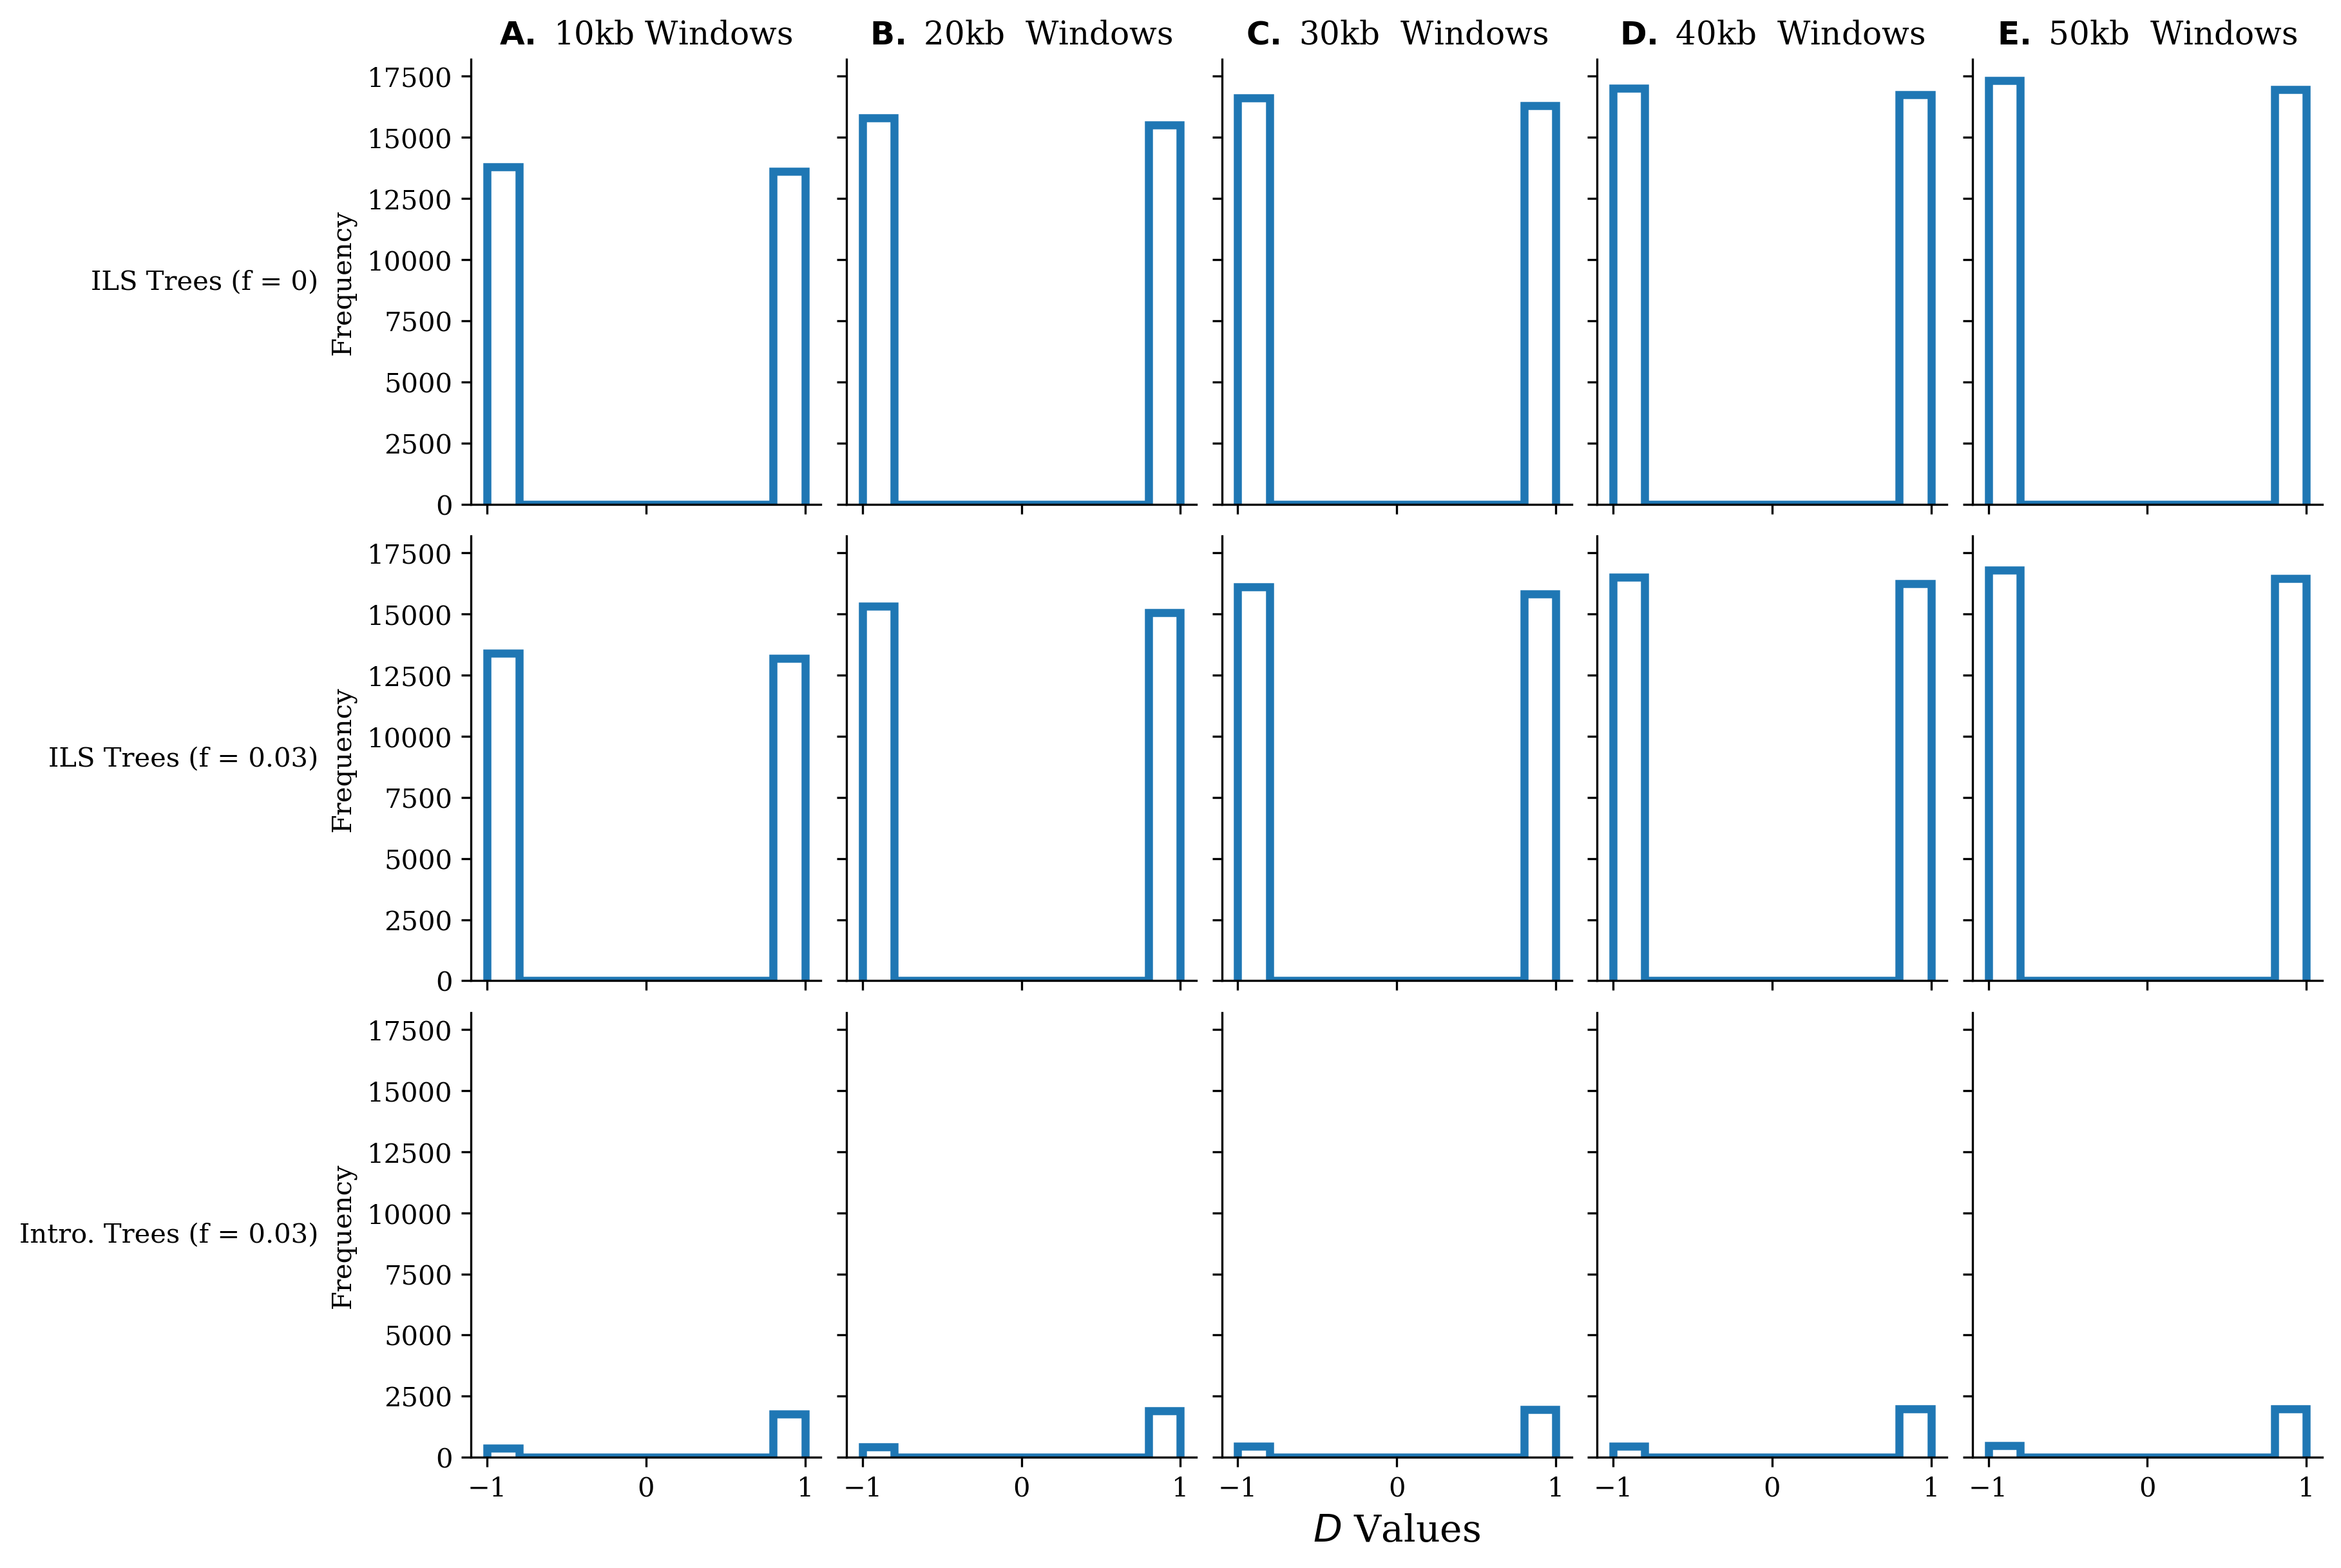

In [15]:
plot_hists(stat='d', title=r'$D$', color='tab:blue')

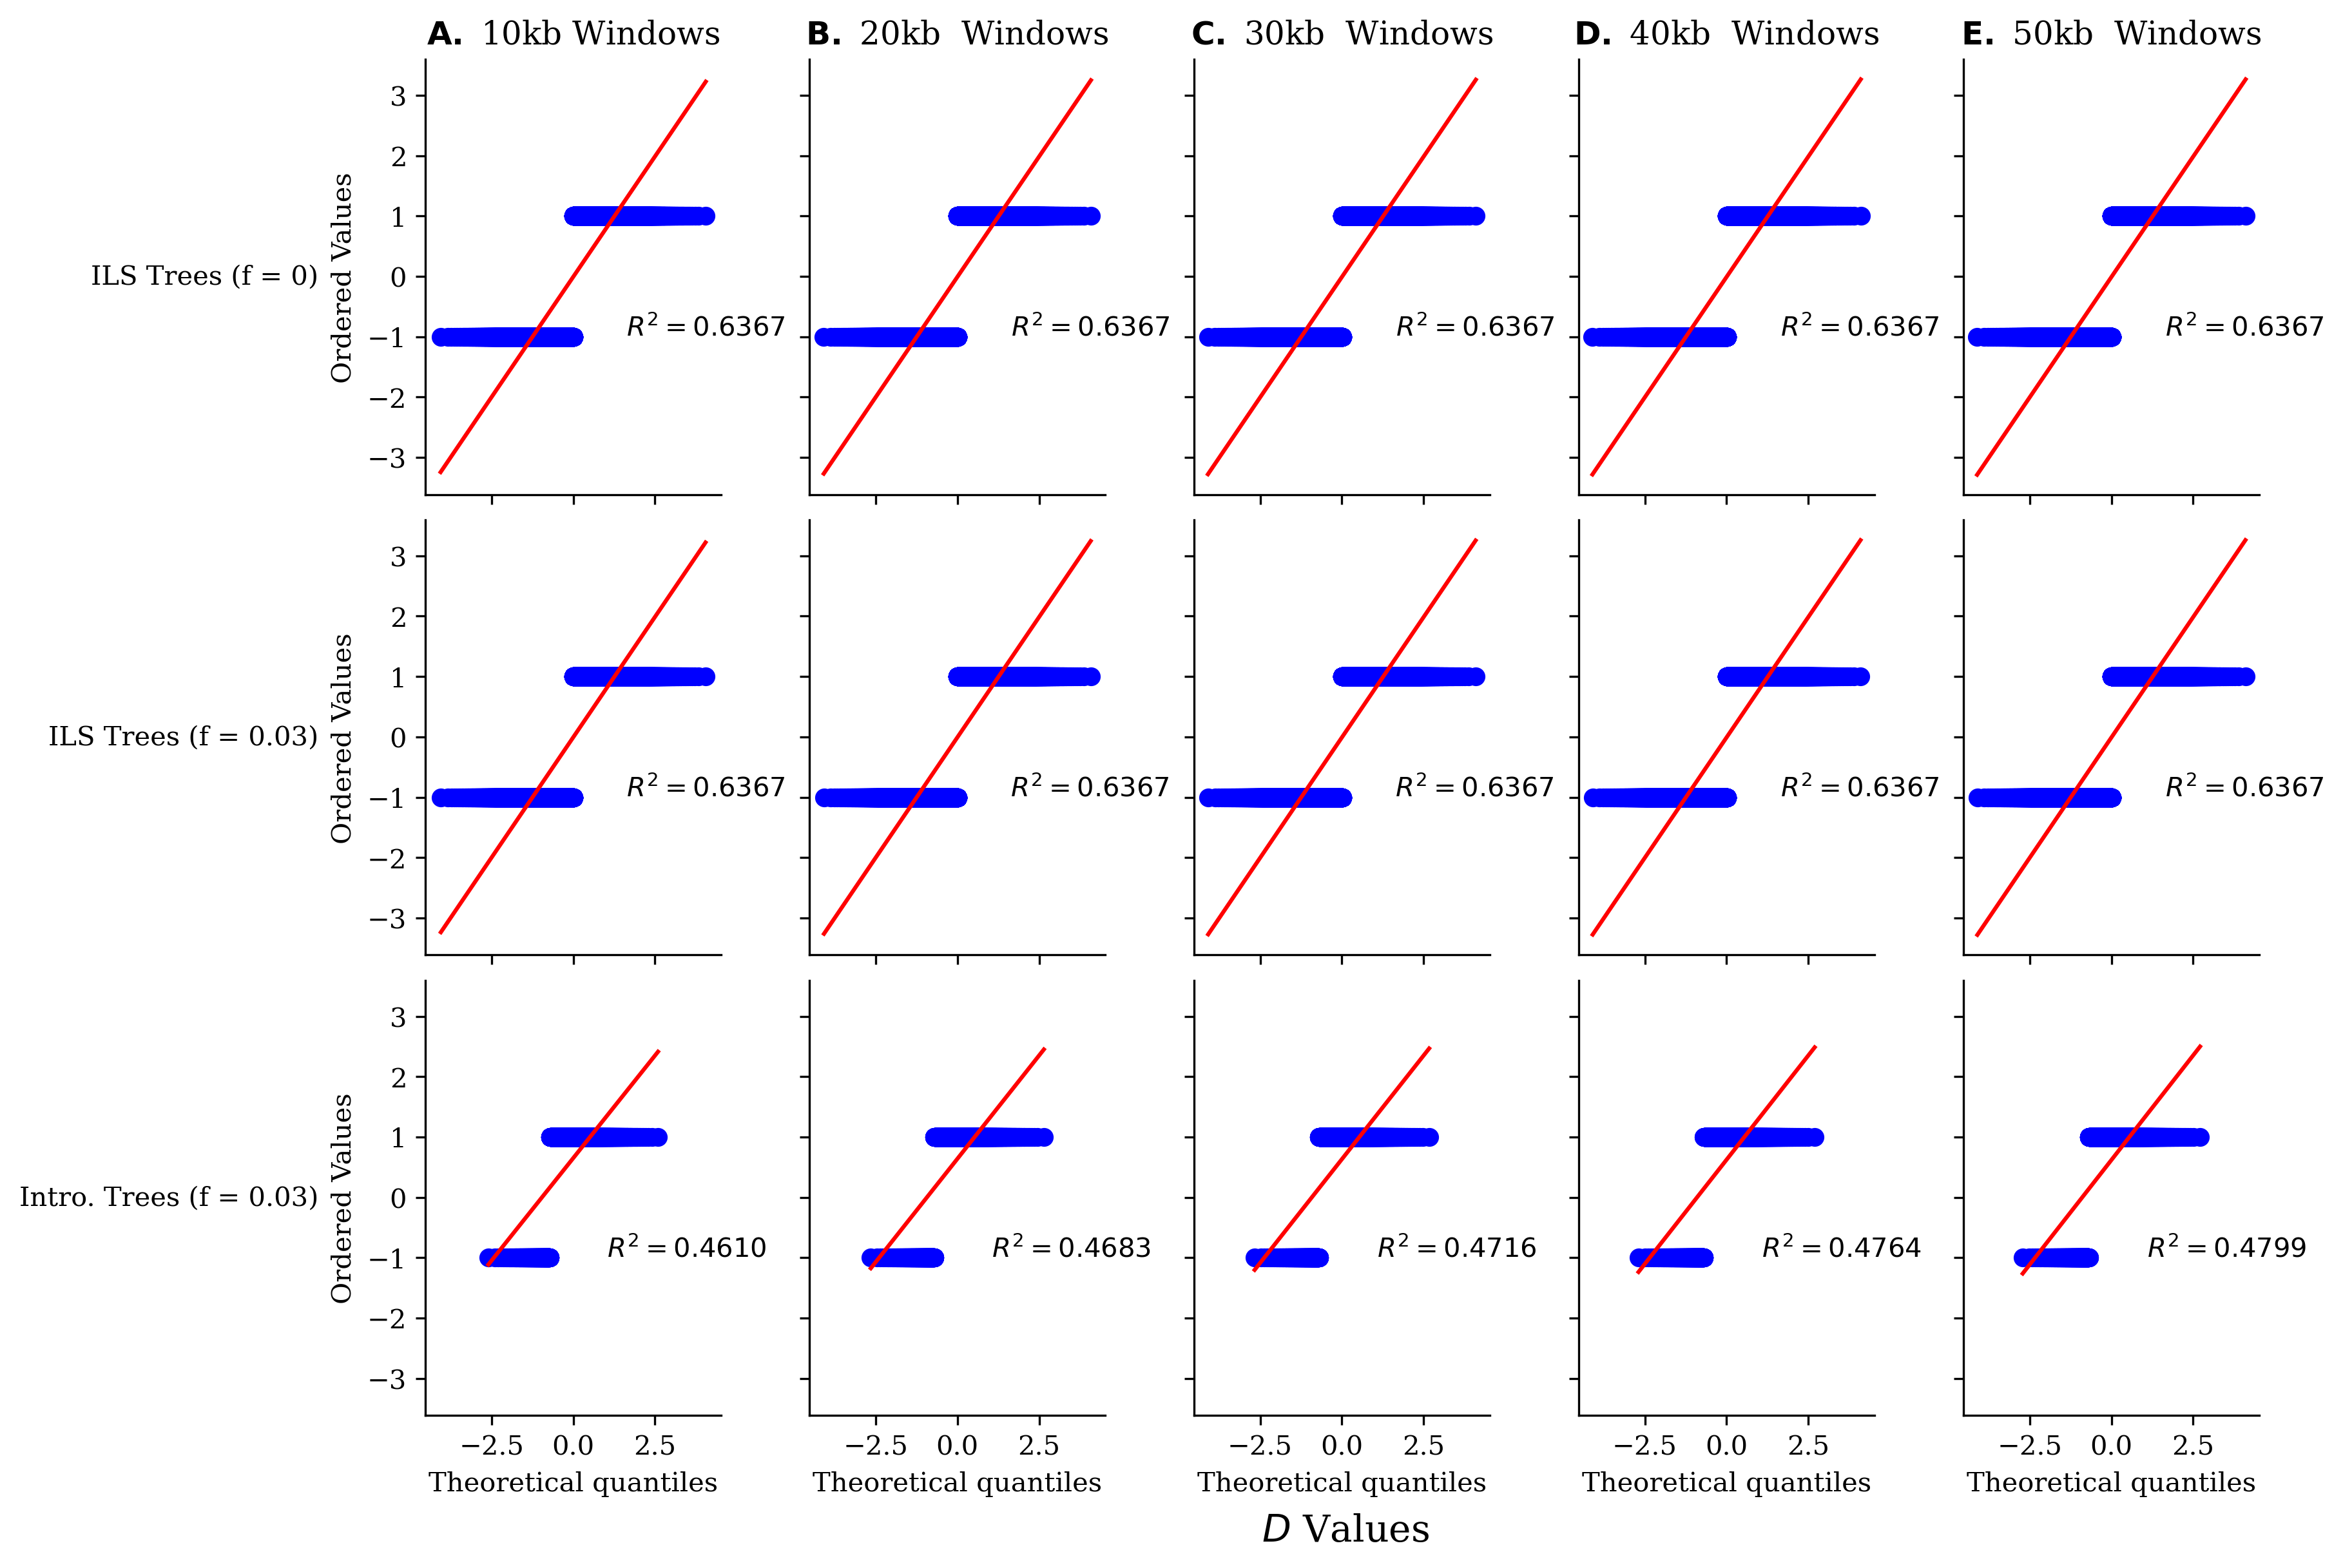

In [16]:
plot_qq(stat='d', title=r'$D$')

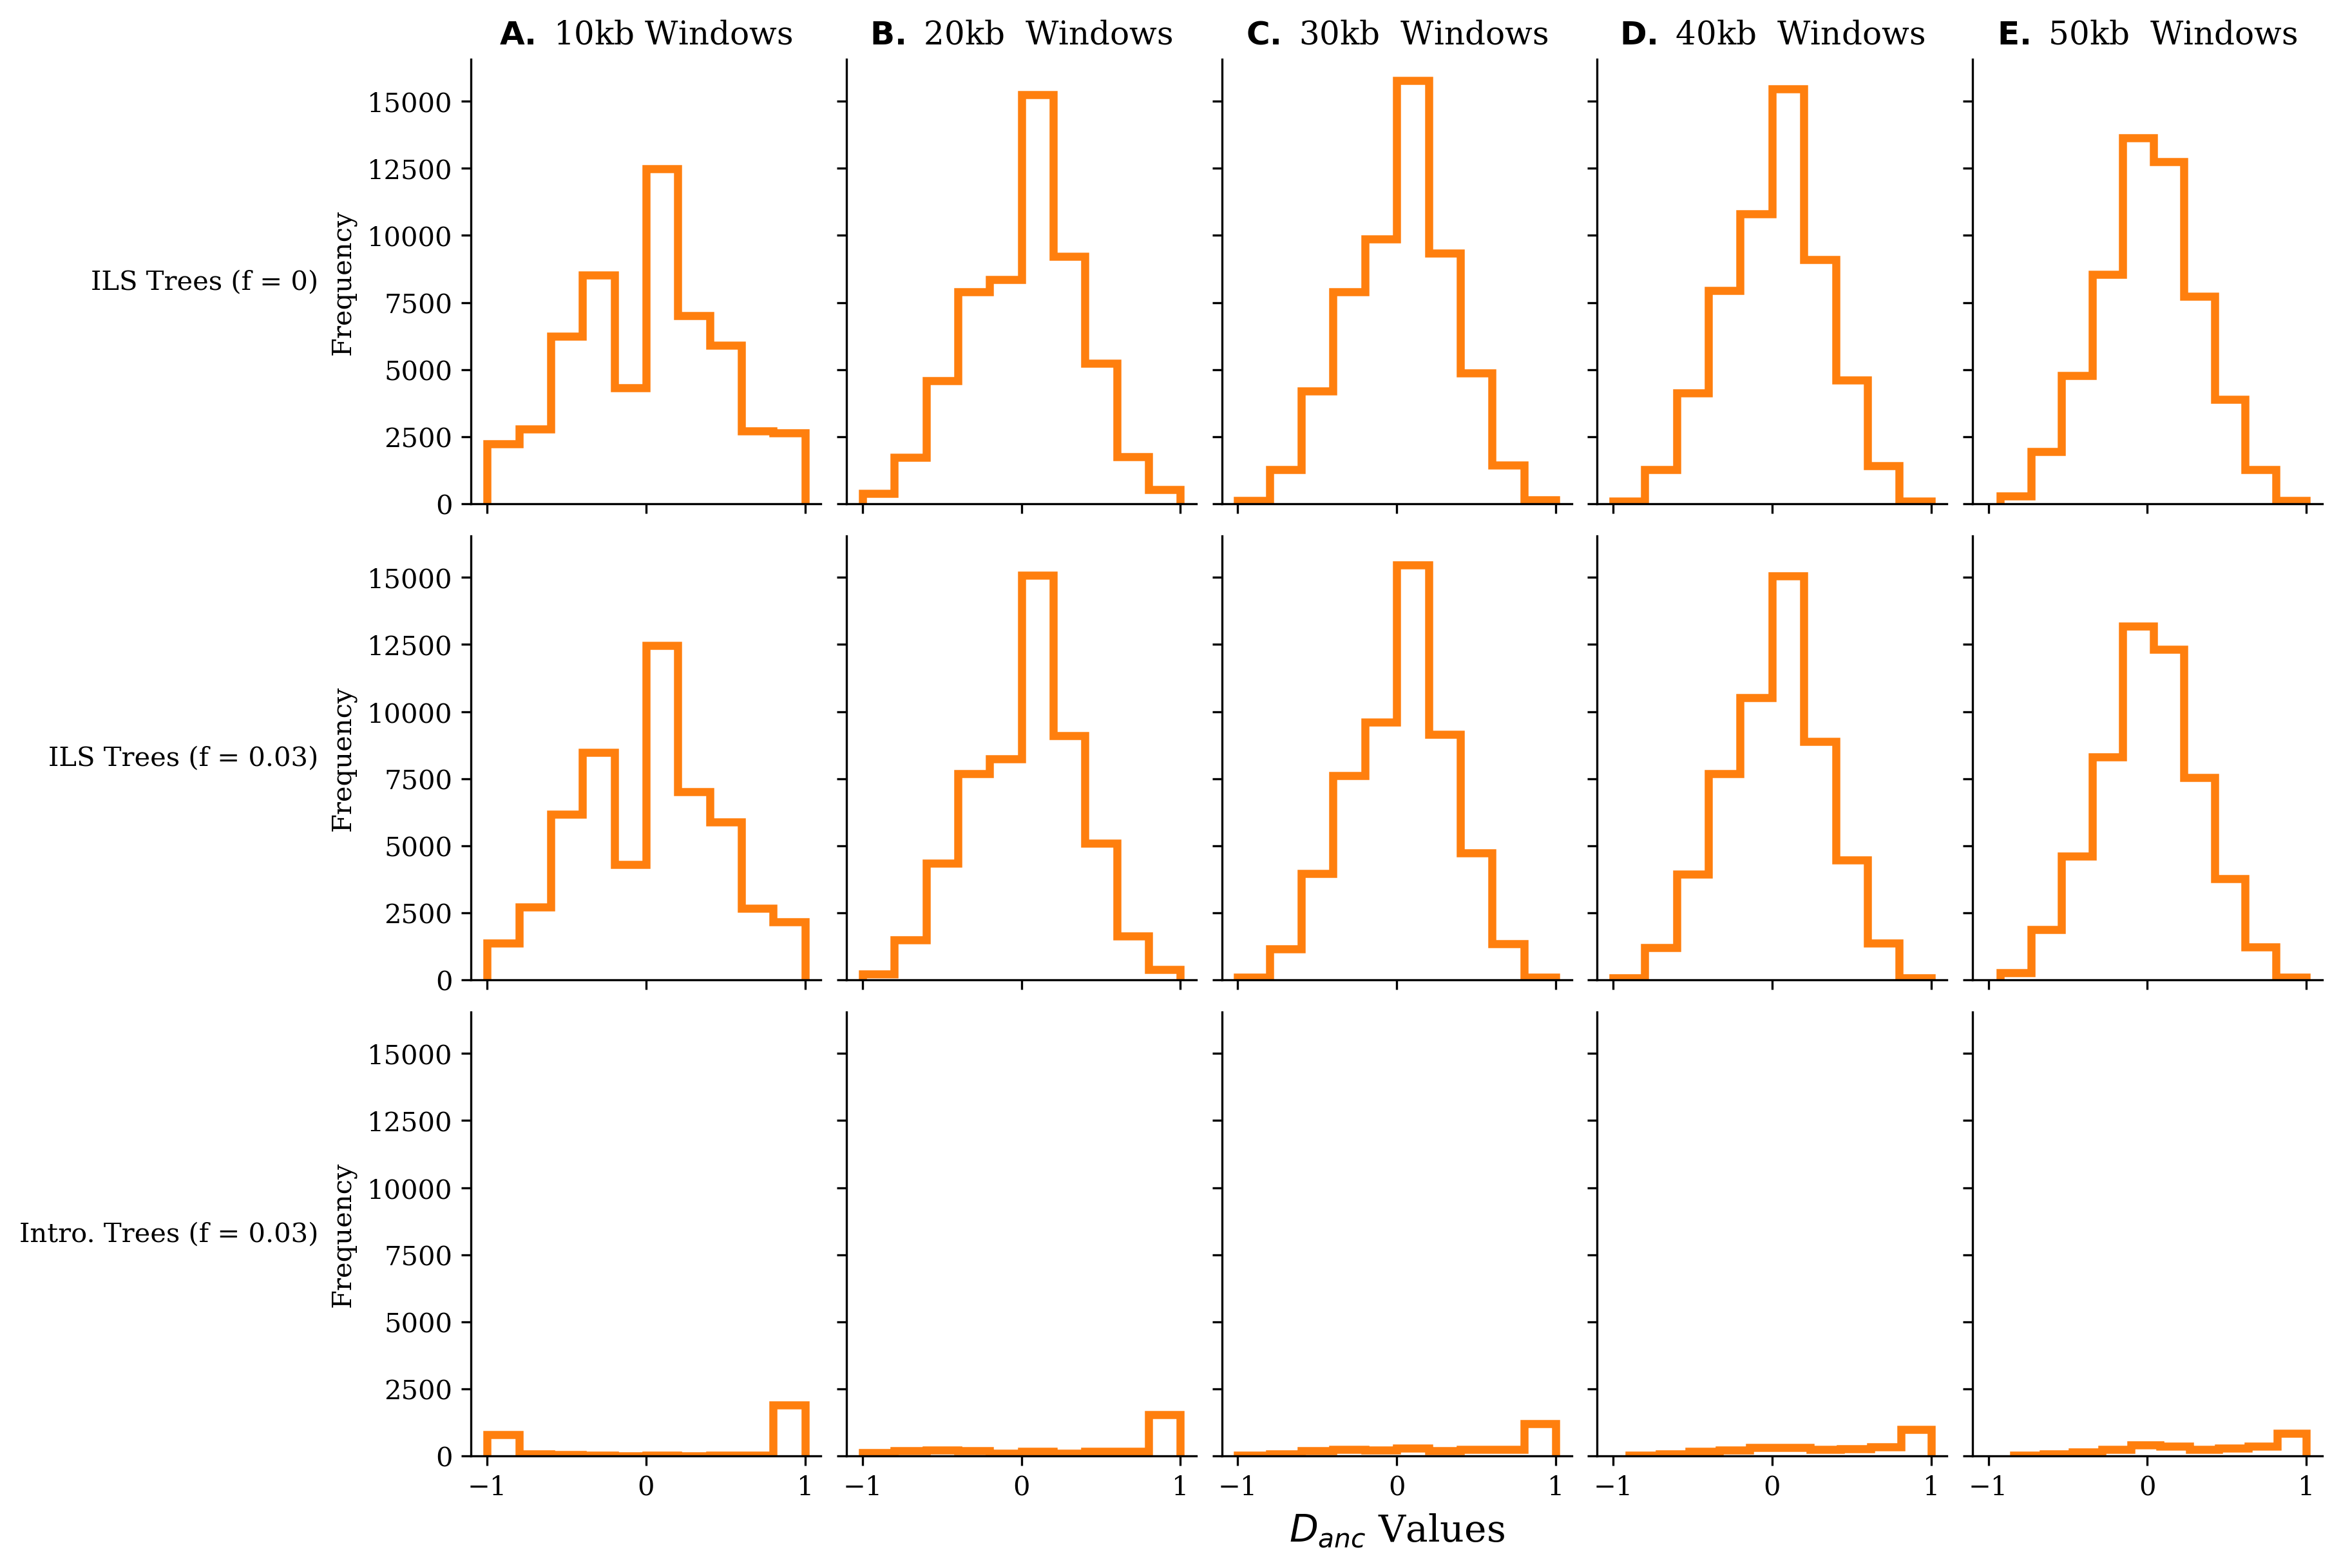

In [17]:
plot_hists(stat='danc', title=r'$D_{anc}$', color='tab:orange')

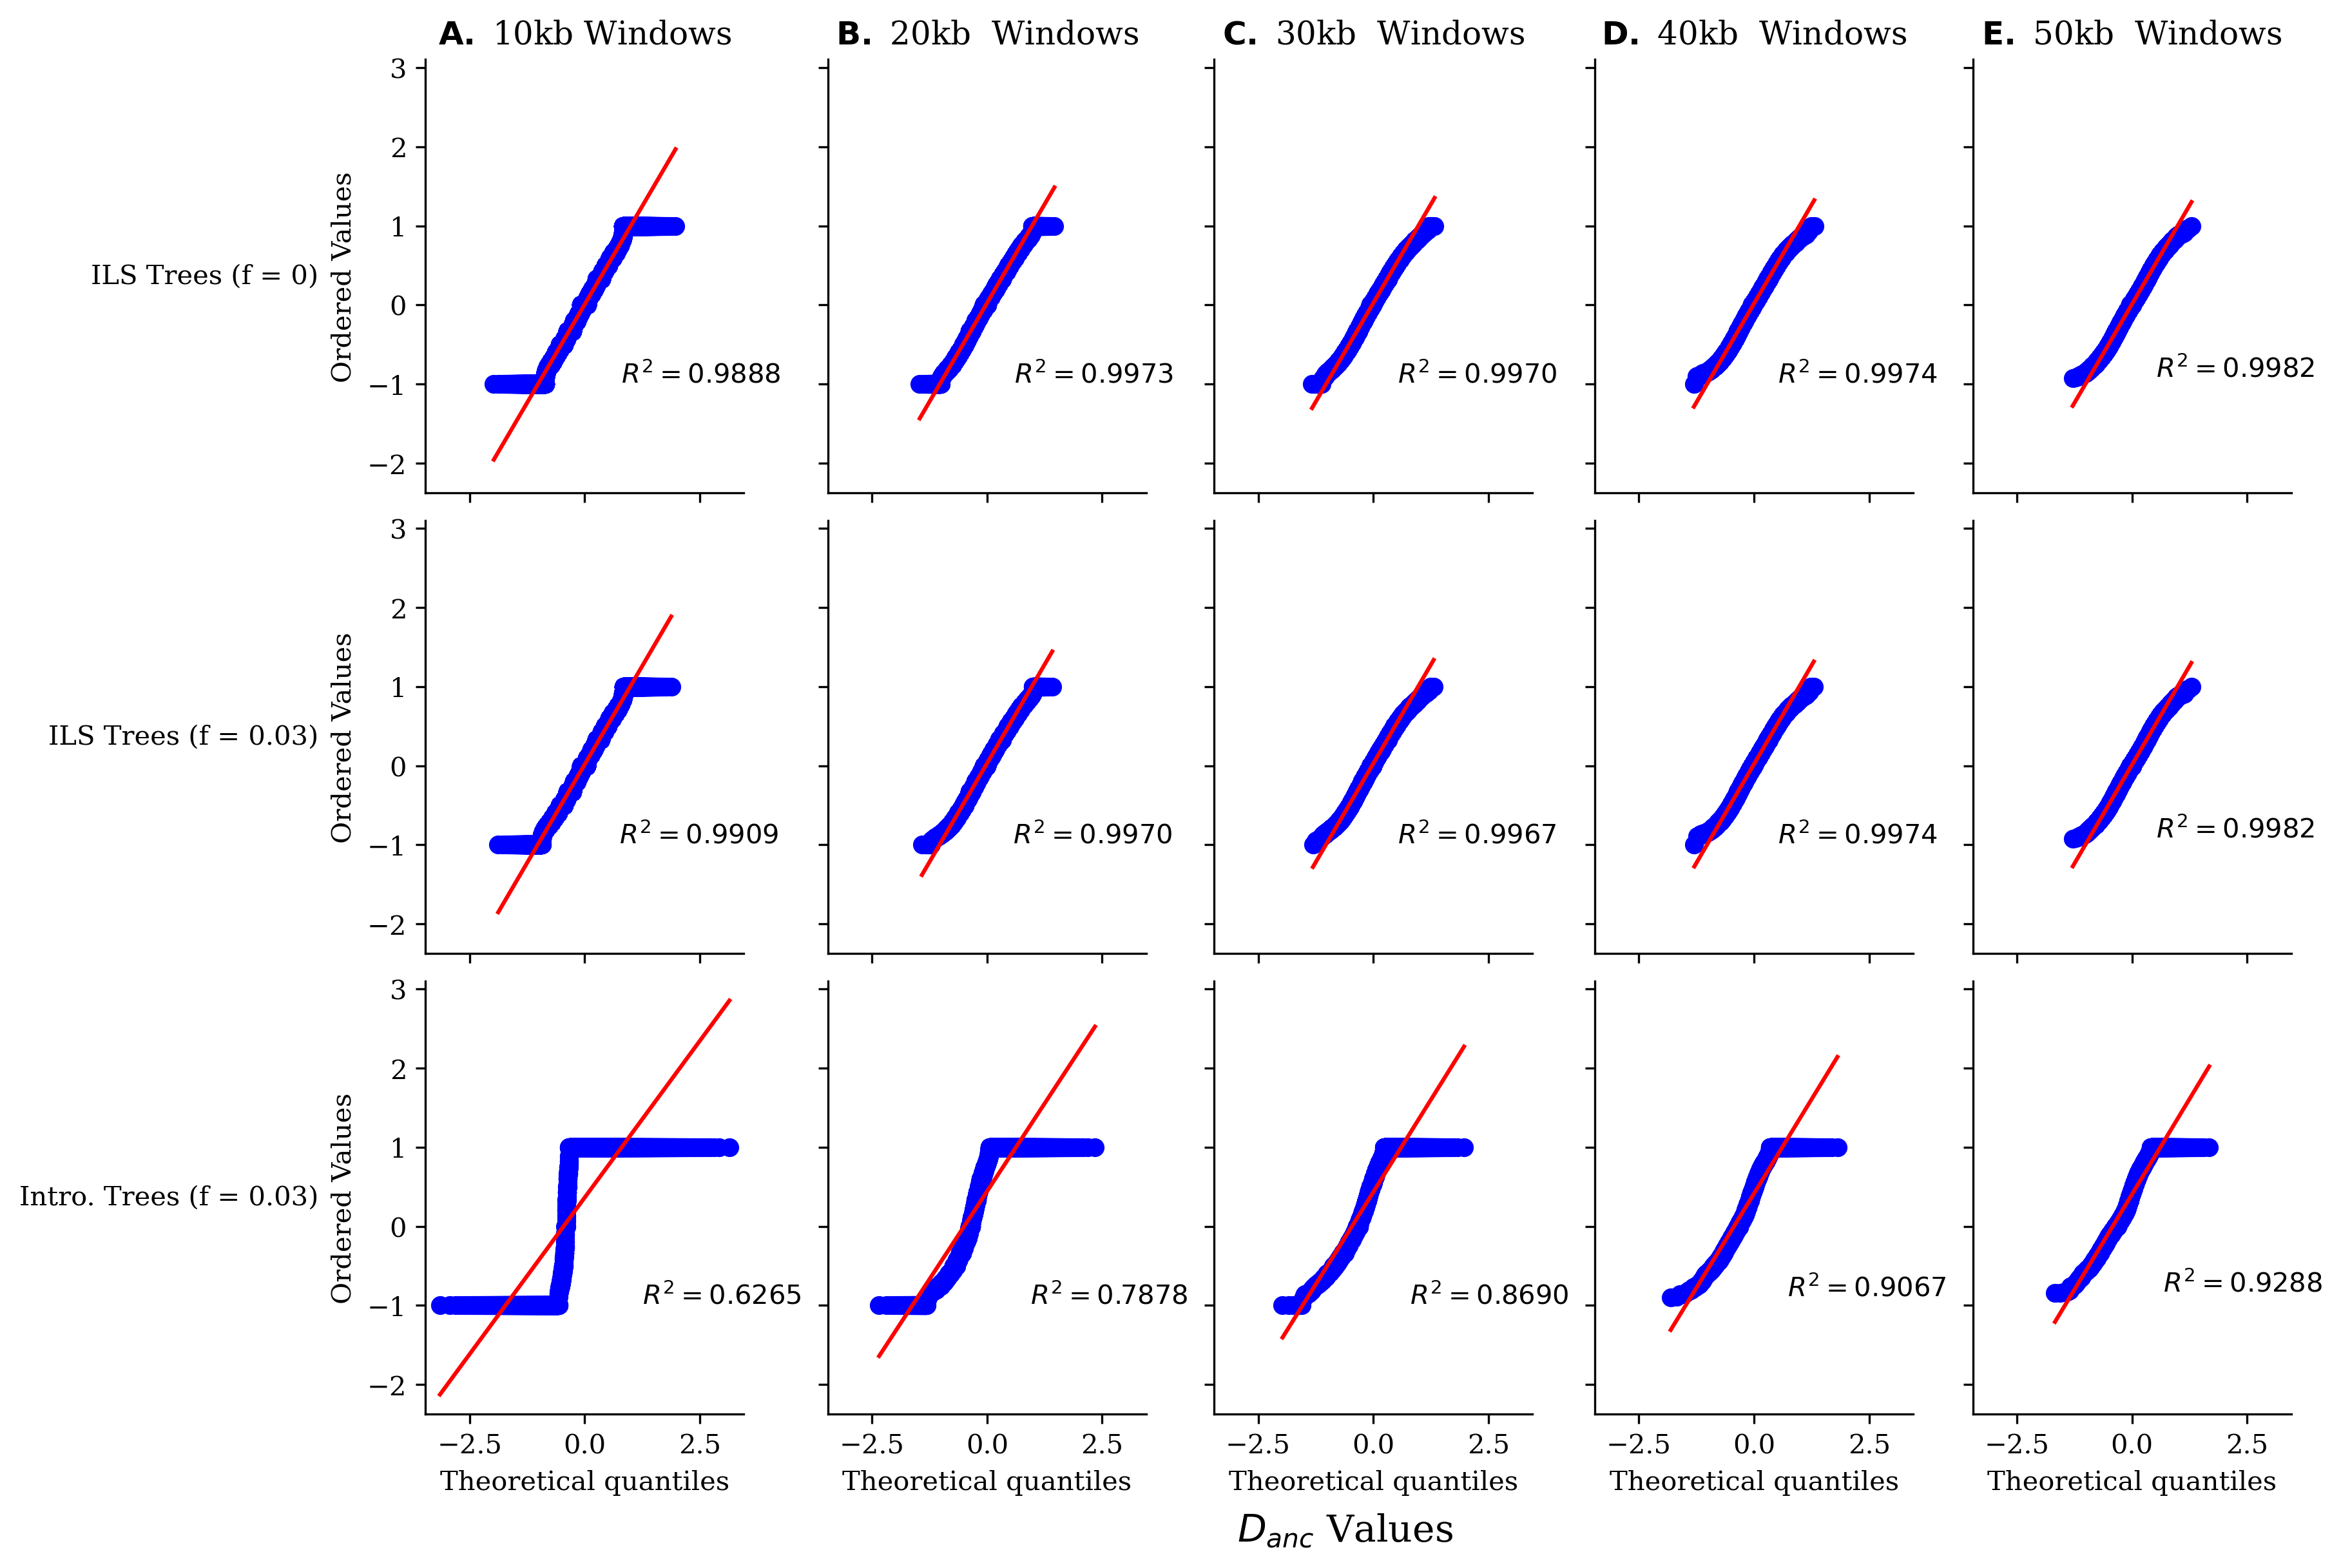

In [18]:
plot_qq(stat='danc', title=r'$D_{anc}$')

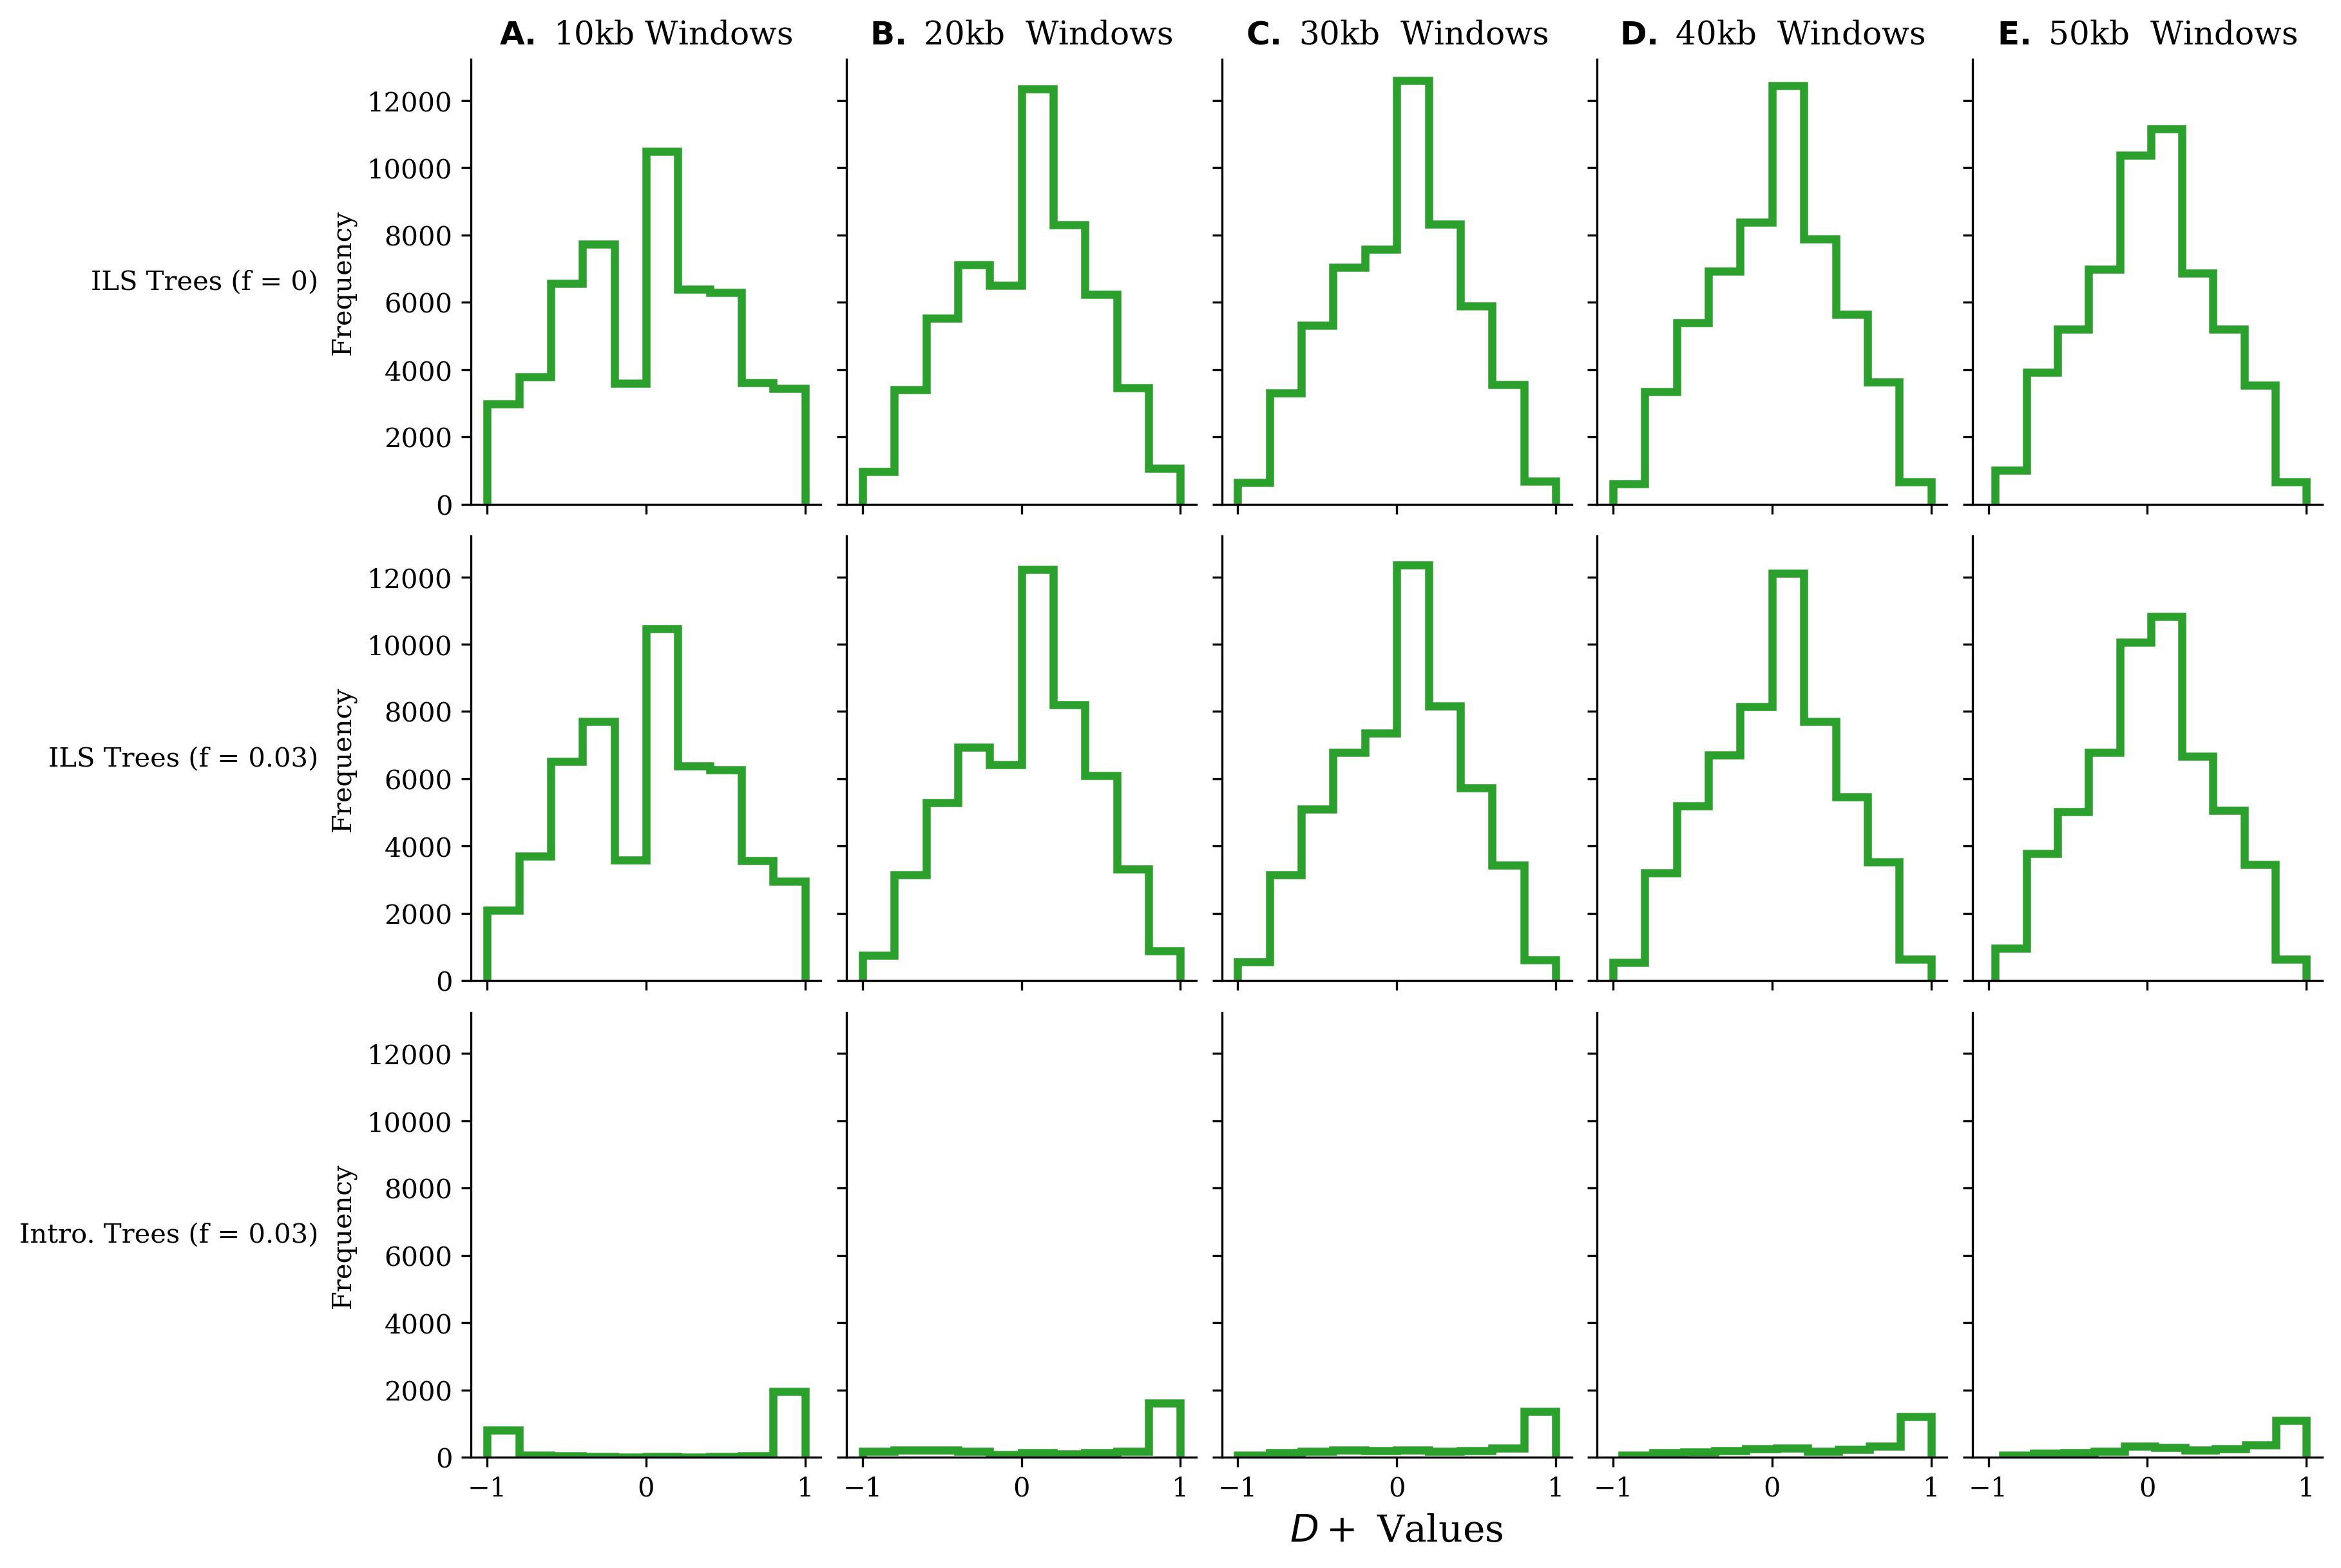

In [19]:
plot_hists(stat='dplus', title=r'$D+$', color='tab:green')

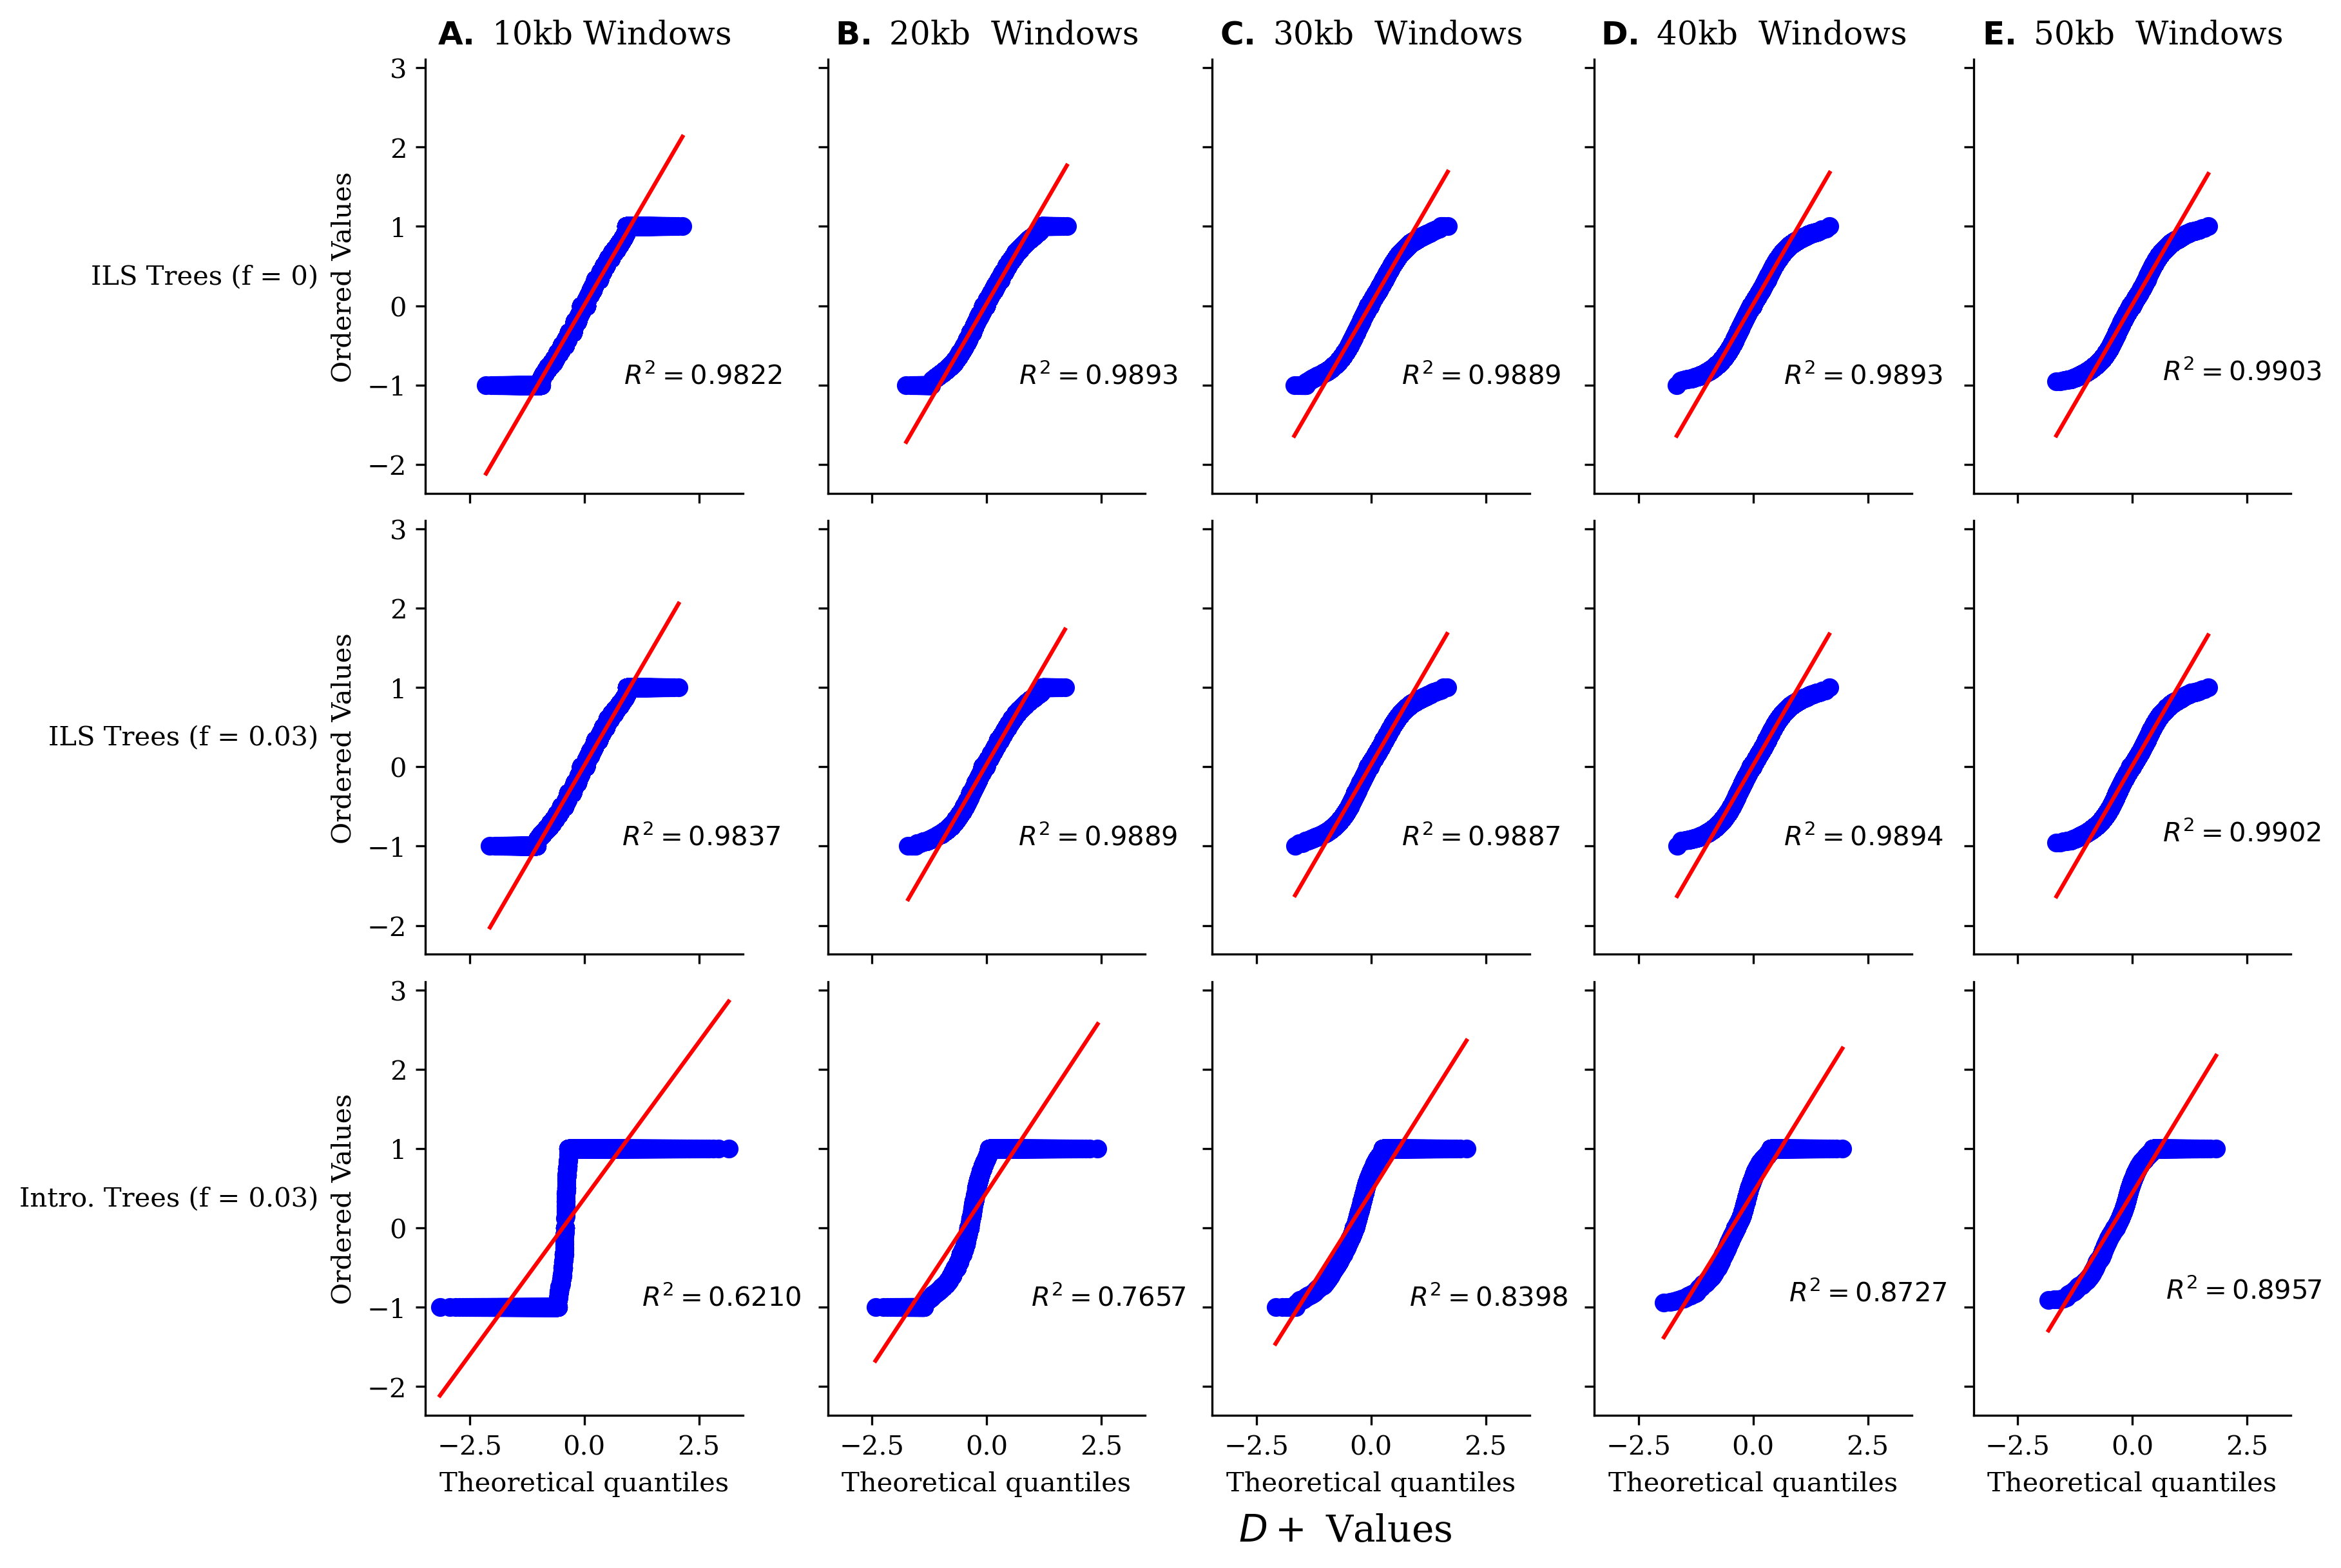

In [20]:
plot_qq(stat='dplus', title=r'$D+$')

> 2A. On the other hand, I am in some degree still skeptical of its performance on identifying local introgression regions. By incomplete lineage sorting (ILS), it is with some probability that each type of gene trees dominates in some local genomic regions. But the two types of ILS are symmetric with equal probability; D and D+ are not affected by ILS when averaged over the whole genome. In a local region, can D+ be informative to distinguish introgression segments from a gene tree of ILS? And it may highly depend on the parameter settings. A more thorough discussion on the difference in data pattern between these two segments will be helpful.

The reviewer is absolutely correct! The probability of ILS is $\frac{1}{3}e^{-\frac{T_{P3}-T_{P2}}{2N}}$ for each of the pairwise possibilities of ILS between P1, P2, and P3; thus, the probability of ILS is greatly influenced by the diffence in divergence times and the effective population size. Here we have simulated 100,000 independet loci of size 10kb, 20kb, 30kb, 40kb, and 50kb for admixture proportions of 0 and 0.03. For each simulation we partioned each locus by coalescent history, then only calculated $D$ and $D+$ for the loci that had coalescent histories of ILS or introgression respectively, and laslty plotted the distributions along with an associated quantile-quantile (Q-Q) plot where we calculated the line of best fit between the theoretical quantiles and observed values using a least-squares regression and subsequently calculated the corresponding coefficient of determination ($R^{2}$). What is unsurprsing is that for coalescent histories of ILS $D$ has a multi-modal distribution; however, $D+$ on the otherhand is approxiametely normally distributed as demonstrated with the Q-Q plots and $R^{2}$ values approaching 1. What is remarkable, is that for coalescent histories of introgression, the distribution of $D$ values is still largely multi-modal while $D+$ exhibits and increasingly left skew as one increases the locus size. Here we have shown that for coalescent histories of ILS $D+$ exhibits its expected approximately normal distribution centered around 0 while for coalescent histories of introgression $D+$ exhibits a left skewed distribution with the highest frequncy bins exhibiting large positive values of $D+$; thus, $D+$ is informative of distinguishing between coalescent histories of ILS and introgression for our given demographic model.